In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../../../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, lrna_price, dynamicadd_lrna_fee, dynamicadd_asset_fee, usd_price, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import price_manipulation, omnipool_arbitrage, price_manipulation_multiple_blocks
from model.amm.global_state import GlobalState, value_assets

In [2]:
omnipool = OmnipoolState(
    tokens = {
        'HDX': {'liquidity': 44000000, 'LRNA': 275143, 'weight_cap': 0.05},
        'WETH': {'liquidity': 1400, 'LRNA': 2276599, 'weight_cap': 0.45},
        'DAI': {'liquidity': 2268262, 'LRNA': 2268262, 'weight_cap': 0.45},
        'DOT': {'liquidity': 88000, 'LRNA': 546461, 'weight_cap': 0.80},
        'WBTC': {'liquidity': 47, 'LRNA': 1145210, 'weight_cap': 0.35},
    },
    asset_fee=0.0025,
    lrna_fee=0.0005,
    preferred_stablecoin='DAI',
)
attacker_funds = 2000000
attacker = Agent(
    # holdings={'DOT': 546461, 'WETH': 700, 'WBTC': 100, 'LRNA': 0},
    # holdings={tkn: omnipool.lrna[tkn] / omnipool.lrna_total / lrna_price(omnipool, tkn) * attacker_funds for tkn in omnipool.asset_list},
    holdings = {tkn: omnipool.weight_cap[tkn] / sum(omnipool.weight_cap.values()) / lrna_price(omnipool, tkn) * attacker_funds for tkn in omnipool.asset_list},
    trade_strategy=price_manipulation_multiple_blocks(
        pool_id='omnipool',
        asset1='DOT',
        asset2='WETH'
    ) + omnipool_arbitrage('omnipool')
)
initial_state = GlobalState(
    pools={
        'omnipool': omnipool
    },
    agents={
        'Attacker': attacker
    }
    # external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
omnipool = initial_state.pools['omnipool']
initial_state.external_market = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

time_steps=2000
events = run.run(initial_state, time_steps=time_steps)

Starting simulation...
Execution time: 3.158 seconds.


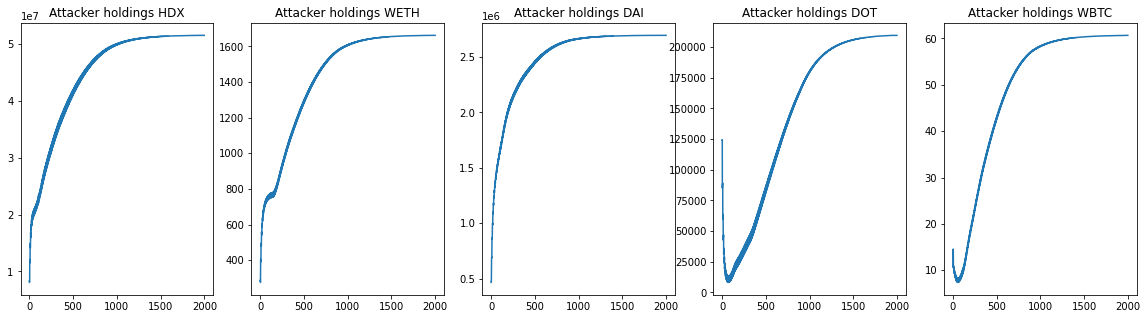

In [3]:
pu.plot(events, agent='Attacker', prop='holdings', key=list(omnipool.asset_list))


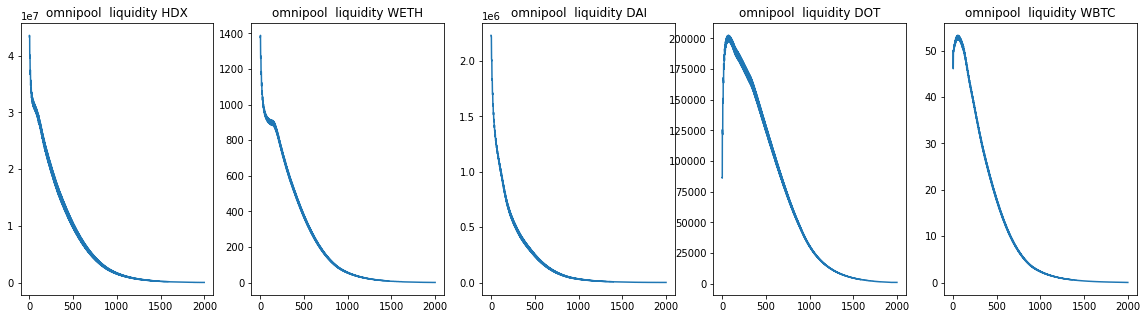

In [4]:
pu.plot(events, pool='omnipool', prop='liquidity')

In [5]:
loss_percent=(1 - events[-1].pool_val(events[-1].pools['omnipool']) / initial_state.pool_val(initial_state.pools['omnipool'])) * 100
attacker_profit = (
    cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['Attacker'], initial_state.external_market)
    - cash_out_omnipool(initial_state.pools['omnipool'], initial_state.agents['Attacker'], initial_state.external_market)
)
print()
print(f'{round(loss_percent, 3)}% of the pool drained in {time_steps} time steps (~{time_steps / 50 * 12} seconds).')
print(f'Attacker profit: ${attacker_profit}')


99.814% of the pool drained in 2000 time steps (~480.0 seconds).
Attacker profit: $6499645.834582733


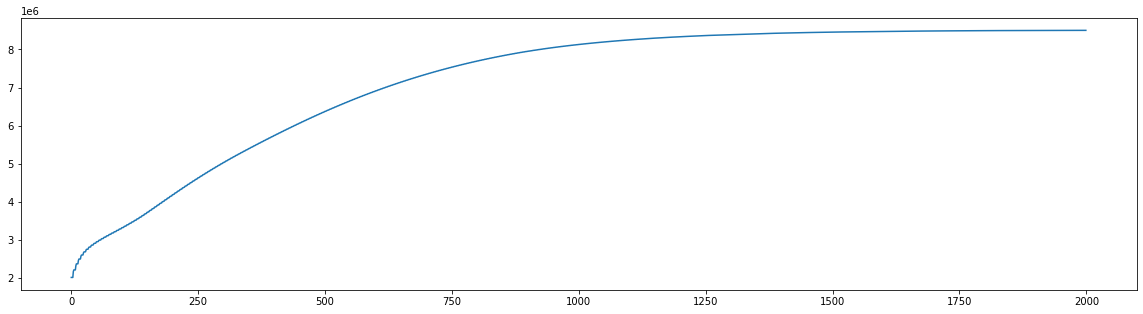

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), [value_assets(event.external_market, event.agents['Attacker'].holdings) for event in events])

In [7]:
print(events[0].pool_val(initial_state.pools['omnipool']))
print(cash_out_omnipool(initial_state.pools['omnipool'], initial_state.agents['Attacker'], initial_state.external_market))

6511675.0
1999999.9999999998


In [8]:
print(events[-1].agents['Attacker'])

Agent: Attacker
********************************
trade strategy: price_manipulation
omnipool arbitrage
holdings: (

    *HDX*: 51559265.16047429

    *WETH*: 1661.8738613242

    *DAI*: 2695545.735829915

    *DOT*: 209578.770072918

    *WBTC*: 60.6461016464

    *('omnipool', 'WBTC')*: -9.147103669115041e+17
    price: 2.8329941122055204e+45

    *LRNA*: 2.6996764262978207e+29

    *('omnipool', 'HDX')*: 0.0
    price: 6.144531515600177e+38

    *('omnipool', 'WETH')*: 0.0
    price: 1.0430106414177282e+44

    *('omnipool', 'DAI')*: 0.0
    price: 6.653910536264094e+40

    *('omnipool', 'DOT')*: 0.0
    price: 4.354835531931087e+41

    *USD*: 0
)

